In [1]:
import math
import string
from keras import layers, models, backend, utils, optimizers
from keras.utils.generic_utils import get_custom_objects
from keras.datasets import cifar10
from matplotlib import pyplot

from custom_objects import Swish
from constants import CONV_KERNEL_INITIALIZER, BASELINE_NETWORK_PARAMS, BlockParams
from weights import IMAGENET_WEIGHTS_PATH, IMAGENET_WEIGHTS_HASHES, NS_WEIGHTS_PATH, NS_WEIGHTS_HASHES

Using TensorFlow backend.


## Load Dataset

In [2]:
(train_x, train_y), (test_x, test_y) = cifar10.load_data()
train_y = utils.to_categorical(train_y)
test_y = utils.to_categorical(test_y)
train_gen, val_gen = train_val_generators()
train_it, train_steps, val_it, val_steps = train_val_iterators(train_x, train_y, test_x, test_y, train_gen, val_gen)

## Preview Dataset

Train: X=(50000, 32, 32, 3), y=(50000, 10)
Test: X=(10000, 32, 32, 3), y=(10000, 10)


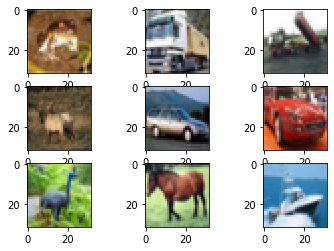

In [3]:
print('Train: X=%s, y=%s' % (train_x.shape, train_y.shape))
print('Test: X=%s, y=%s' % (test_x.shape, test_y.shape))
# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# plot raw pixel data
	pyplot.imshow(train_x[i])
# show the figure
pyplot.show()

## Helper Functions

In [4]:
def round_num_filters(base_filters, width_coeff, rounding_multiple=8):
    """To match the pretrained weights for EfficientNet, we need to round num filters to nearest multiple of 8."""
    # To round to the nearest multiple of a number: https://stackoverflow.com/questions/29557459/round-to-nearest-multiple-of-a-number
    filters = base_filters * width_coeff
    if not rounding_multiple:
        return filters
    rounded_filters = (int(filters + 4) // rounding_multiple) * rounding_multiple
    # Minimum num filters is 8 (makes sense but I copied this part)
    rounded_filters = max(rounding_multiple, rounded_filters)
    # Do not want to round down by more than 10% (makes sense but I copied this part)
    if rounded_filters < 0.9*filters:
        rounded_filters += rounding_multiple
    return int(rounded_filters)

In [5]:
def round_num_repeats(base_repeats, depth_coefficient):
    return int(math.ceil(base_repeats * depth_coefficient))

In [6]:
def scaled_dropout(drop_connect_rate, block_num, total_blocks):
    return drop_connect_rate * float(block_num) / total_blocks

In [7]:
import collections

def flatten(x):
    """Flatten nested list."""
    return [a for i in x for a in flatten(i)] if isinstance(x, collections.Iterable) else [x]

In [8]:
import itertools
import matplotlib.pyplot as plt

def plot_layer_weights(layer, input_shape=[None,224,224,3]):
    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        sess.run(init)
        input_x = tf.placeholder(tf.float32, shape=input_shape, name='input_x')  
        y = layer(input_x)
        weights = flatten(x.get_weights()[0].tolist())
        plt.hist(weights)

## MBConv Block Implementation

In [9]:
# The original MobileNetV2 network uses RELU6 as its activation function, but EfficientNet uses swish.  As a result we will add the activation function as a param
def mb_conv_block(input_layer, block_params, block_prefix, bn_axis=3, activation_fn="swish", drop_rate=None):
    # Expansion Phase
    x = input_layer
    if block_params.expand_ratio != 1:
        x = layers.Conv2D(int(block_params.input_filters*block_params.expand_ratio), 1, padding='same', use_bias=False, name=f"{block_prefix}expand_conv")(x)
        x = layers.BatchNormalization(axis=bn_axis, name=f"{block_prefix}expand_bn")(x)
        x = layers.Activation(activation_fn, name=f"{block_prefix}expand_activation")(x)
    # Depthwise Convolution
    x = layers.DepthwiseConv2D(block_params.depthwise_kernel_size, strides=block_params.depthwise_strides, padding='same', use_bias=False, name=f"{block_prefix}dwconv")(x)
    x = layers.BatchNormalization(axis=bn_axis, name=f"{block_prefix}bn")(x)
    x = layers.Activation(activation_fn, name=f"{block_prefix}activation")(x)
    # Squeeze and Excitation
    squeeze_filter_size = max(1, int(block_params.input_filters*block_params.se_ratio))
    target_shape = (1, 1, int(block_params.input_filters*block_params.expand_ratio)) if bn_axis==3 else (int(block_params.input_filters*block_params.expand_ratio), 1, 1)
    se = layers.GlobalAveragePooling2D(name=f"{block_prefix}se_squeeze")(x)
    se = layers.Reshape(target_shape, name=f"{block_prefix}se_reshape")(se)
    se = layers.Conv2D(squeeze_filter_size, 1, padding='same', activation=activation_fn, use_bias=True, name=f"{block_prefix}se_reduce")(se)
    se = layers.Conv2D(int(block_params.input_filters*block_params.expand_ratio), 1, padding='same', activation='sigmoid', use_bias=True, name=f"{block_prefix}se_expand")(se) # We are getting weights for the features between 0 and 1, making sigmoid a good choice here
    x = layers.multiply([x, se], name=f"{block_prefix}se_excite")
    # Projection Phase
    x = layers.Conv2D(block_params.output_filters, 1, padding='same', use_bias=False, name=f"{block_prefix}project_conv")(x)
    x = layers.BatchNormalization(axis=bn_axis, name=f"{block_prefix}project_bn")(x)
    if block_params.input_filters == block_params.output_filters and all([x == 1 for x in block_params.depthwise_strides]):
        if drop_rate and drop_rate > 0:
            print("here", drop_rate)
            x = layers.Dropout(drop_rate, name=f"{block_prefix}drop")(x)
        x = layers.add([x, input_layer], name=f"{block_prefix}add")
    return x

## EfficientNet Skeleton

In [10]:
def verify_model_input(input_tensor, input_shape, alpha, beta, gamma, phi):
    if alpha < 1 or beta < 1 or gamma < 1:
        raise ValueError("Alpha, Beta, and Gamma all need to be >= 1")
    if phi < 0:
        raise ValueError("Phi must be >= 0")
    if input_tensor is None and input_shape is None:
        raise ValueError("EfficientNet must be provided with either an input_tensor or an input_shape!")

In [11]:
def build_stem(x, width_coeff, bn_axis):
    x = layers.Conv2D(round_num_filters(32, width_coeff), kernel_size=3, strides=(2, 2), padding="same", use_bias=False, kernel_initializer=CONV_KERNEL_INITIALIZER, name="stem_conv")(x)
    x = layers.BatchNormalization(axis=bn_axis, name='stem_bn')(x)
    return layers.Activation("swish", name="stem_activation")(x)

In [12]:
def build_top(x, width_coeff, bn_axis):
    x = layers.Conv2D(round_num_filters(1280, width_coeff), 1, padding='same', use_bias=False, kernel_initializer=CONV_KERNEL_INITIALIZER, name='top_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, name='top_bn')(x)
    x = layers.Activation("swish", name='top_activation')(x)
    return layers.GlobalAveragePooling2D(name='avg_pool')(x)

In [13]:
def efficientnet(input_tensor=None, input_shape=None, phi=0, model_name="efficientnet_base", image_data_format="channels_last", drop_connect_rate=0.2, alpha=1.2, beta=1.1, gamma=1.15):
    verify_model_input(input_tensor, input_shape, alpha, beta, gamma, phi)
    bn_axis = 3 if image_data_format=="channels_last" else 1
    # EfficientNet B0 Values (alpha = depth (num layers), beta = width (num filters), gamma = resolution)
    depth_coeff, width_coeff, res_coeff = alpha**phi, beta**phi, gamma**phi
    # Create Stem
    input_layer = Input(shape=input_shape) if input_tensor is None else input_tensor
    x = build_stem(input_layer, width_coeff, bn_axis)
    # x = layers.Conv2D(round_num_filters(32, width_coeff, rounding_multiple=8), kernel_size=3, strides=(2, 2), padding="same", use_bias=False, kernel_initializer=CONV_KERNEL_INIT, name="stem_conv")(input_layer)
    # x = layers.BatchNormalization(axis=bn_axis, name='stem_bn')(x)
    # x = layers.Activation("swish", name="stem_activation")(x)
    # Build MBConv Blocks
#     I feel like total_network_blocks should include the actual number of repeats due to depth_coeff as well...
    total_network_blocks = sum(round_num_repeats(block.num_repeat, depth_coeff) for block in BASELINE_NETWORK_PARAMS)
    block_num = 0
    for idx, block_params in enumerate(BASELINE_NETWORK_PARAMS):
        drop_rate = scaled_dropout(drop_connect_rate, block_num, total_network_blocks)
        rounded_repeats = round_num_repeats(block_params.num_repeat, depth_coeff)
        rounded_inputs = round_num_filters(block_params.input_filters, width_coeff)
        rounded_outputs = round_num_filters(block_params.output_filters, width_coeff)
        updated_params = BlockParams(depthwise_kernel_size=block_params.depthwise_kernel_size, num_repeat=rounded_repeats, input_filters=rounded_inputs, output_filters=rounded_outputs,
              expand_ratio=block_params.expand_ratio, depthwise_strides=block_params.depthwise_strides, se_ratio=block_params.se_ratio)
        x = mb_conv_block(x, updated_params, "block{}a_".format(idx+1), bn_axis=3, activation_fn="swish", drop_rate=drop_rate)
        # x = new_mb_conv_block(x, input_filters, output_filters, "block{}a_".format(idx+1), depthwise_kernel_size=block_params.depthwise_kernel_size, depthwise_strides=block_params.strides, se_ratio=block_params.se_ratio, drop_rate=drop_rate, expand_ratio=block_params.expand_ratio)
        block_num += 1
        # If repeated block
        if rounded_repeats > 1:
            # Note we already repeated the first block
            for bidx in range(1, rounded_repeats):
                drop_rate = scaled_dropout(drop_connect_rate, block_num, total_network_blocks)
                # Input filters needs to be changed so that it matches the first block's output filters
                updated_params = BlockParams(depthwise_kernel_size=block_params.depthwise_kernel_size, num_repeat=rounded_repeats, input_filters=rounded_outputs, output_filters=rounded_outputs,
                    expand_ratio=block_params.expand_ratio, depthwise_strides=[1, 1], se_ratio=block_params.se_ratio)
                x = mb_conv_block(x, updated_params, "block{}{}_".format(idx+1, string.ascii_lowercase[bidx]), bn_axis=3, activation_fn="swish", drop_rate=drop_rate)
                # x = new_mb_conv_block(x, output_filters, output_filters, "block{}{}_".format(idx+1, string.ascii_lowercase[bidx]), depthwise_kernel_size=block_params.depthwise_kernel_size, depthwise_strides=[1, 1], se_ratio=block_params.se_ratio, drop_rate=drop_rate, expand_ratio=block_params.expand_ratio)
                block_num += 1
    # Build Top
    # Final conv layer in provided baseline network
    x = build_top(x, width_coeff, bn_axis)
    
    # Return output
    return x

## Build Model

In [14]:
get_custom_objects().update({'swish': Swish()})
image_data_format = backend.image_data_format()

In [15]:
model_input = layers.Input((32, 32, 3))
# model_input = layers.Input((150, 150, 3))
base_output = efficientnet(model_input)
base_model = models.Model(model_input, base_output)
x = layers.BatchNormalization()(base_model.output)
x = layers.Dropout(0.3)(x)
x = layers.Dense(512)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("swish")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("swish")(x)
predictions = layers.Dense(10, activation='softmax')(x)
model = models.Model(base_model.input, predictions)
model.summary()

here 0.025
here 0.05
here 0.07500000000000001
here 0.08750000000000001
here 0.1125
here 0.125
here 0.15000000000000002
here 0.1625
here 0.17500000000000002
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 16, 16, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 16, 16, 32)   128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 16, 16, 32)  

## Load Weights

In [16]:
model_name='efficientnet-b0'
file_name = model_name + '_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5'
file_hash = IMAGENET_WEIGHTS_HASHES[model_name][1]
weights_path = utils.get_file(
            file_name,
            IMAGENET_WEIGHTS_PATH + file_name,
            cache_subdir='models',
            file_hash=file_hash,
        )

In [17]:
model.load_weights(weights_path, by_name=True)

In [18]:
# Probabilities produced by softmax will always sum to 1
default_adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
slow_adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='categorical_crossentropy',optimizer=default_adam,metrics=['accuracy'])

## Prepare Dataset

In [19]:
from data_loader import train_val_test_generators
train_gen, val_gen, test_gen = train_val_test_generators()

In [21]:
train_it = train_gen.flow(train_x, train_y, batch_size=32, shuffle=True)
val_it = val_gen.flow(test_x, test_y, batch_size=100)
train_steps = train_it.n//train_it.batch_size
val_steps = val_it.n // val_it.batch_size

model.fit_generator(train_it, steps_per_epoch=train_steps, epochs=10, validation_data=val_it, validation_steps=val_steps)

# from keras.models import Sequential, Model
# from keras.preprocessing.image import ImageDataGenerator
# from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# train_steps = train_generator.n//train_generator.batch_size
# validation_steps = validation_generator.n//validation_generator.batch_size
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
# mc = ModelCheckpoint('vgg_16_step_1.h5', monitor='val_loss', mode='min', save_best_only=True)
# learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.5, min_lr=0.0000001)
# history = model.fit_generator(train_generator,steps_per_epoch=train_steps, epochs=60,
#                               validation_data=validation_generator,validation_steps=validation_steps,
#                               callbacks=[es, mc, learning_rate_reduction],
#                               workers=6, max_queue_size=30)

Epoch 1/10
1562/1562 [==============================] - 69s 44ms/step - loss: 1.4864 - acc: 0.4814 - val_loss: 1.1976 - val_acc: 0.5821
Epoch 2/10
1562/1562 [==============================] - 61s 39ms/step - loss: 1.2135 - acc: 0.5816 - val_loss: 1.1137 - val_acc: 0.6257
Epoch 3/10
1562/1562 [==============================] - 60s 39ms/step - loss: 1.1126 - acc: 0.6179 - val_loss: 0.9559 - val_acc: 0.6638
Epoch 4/10
1562/1562 [==============================] - 60s 38ms/step - loss: 1.0442 - acc: 0.6427 - val_loss: 0.9818 - val_acc: 0.6664
Epoch 5/10
1562/1562 [==============================] - 60s 38ms/step - loss: 1.0066 - acc: 0.6558 - val_loss: 0.9336 - val_acc: 0.6770
Epoch 6/10
1562/1562 [==============================] - 60s 38ms/step - loss: 0.9573 - acc: 0.6727 - val_loss: 0.9461 - val_acc: 0.6819
Epoch 7/10
1562/1562 [==============================] - 60s 38ms/step - loss: 0.9271 - acc: 0.6840 - val_loss: 0.8929 - val_acc: 0.6938
Epoch 8/10
1562/1562 [==========================